In [105]:
import numpy as np
from numpy import pi
from numpy.linalg import norm
from matplotlib import pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter

## 算法

### 时延估计


### 远/近场方位解算算法


In [106]:
def far_locate(t12_f, t23_f, c, K, d):  # FIXME: 还是模糊相位角?
    """远场条件下的定位

    Parameters
    ----------
    t12_f : float
        tau12模糊时延
    t23_f : float
        tau23模糊时延

    Returns
    -------
    r_e : float
        距离估计值
    theta_e : float
        方位角估计值
    """
    t12_e, t23_e = t12_f, t23_f  # TODO: 解模糊
    t13_e = t12_e + t23_e
    theta_e = np.arccos((c * t13_e) / ((K + 1) * d))
    r_e = (
        K * (K + 1) * ((d * np.sin(theta_e)) ** 2)
        / (2 * c * (K * t12_e - t23_e))
    )
    return r_e, theta_e

## 仿真


### 声场仿真


设置参数


In [107]:
c = 1500
f = 37500
K = 1
d = 0.015
r = 100
theta = 60 / 180 * pi

fs = f * 200  # 采样频率1M
T = 1  # 采样时长

In [108]:
# 分形噪声, 见: https://pvigier.github.io/2018/06/13/perlin-noise-numpy.html
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise

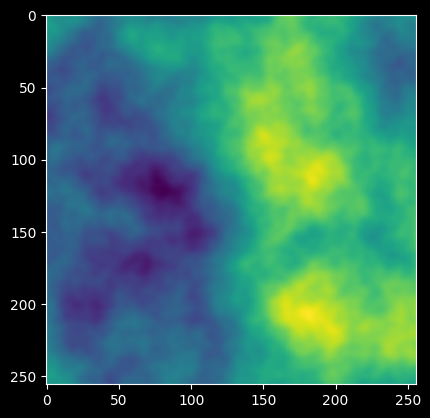

In [109]:
n = generate_fractal_noise_2d((256, 256), (1, 1), octaves=6)
plt.imshow(n)

In [110]:
noise = n.flatten() / np.max(n)
noise = np.tile(noise, 1 + T * fs // (len(noise)))[:int(T * fs)]

In [111]:
def sig_gen(c: float, f: float, r: float, fs: float, T: float) -> np.ndarray:
    """生成距声源r处信号

    Parameters
    ----------
    c : float
        声速
    f : float
        声源发声频率
    r : float
        信号采样点距声源距离
    fs : float
        采样频率
    T : float
        采样时长

    Returns
    -------
    list
        信号序列s[r, n]
    """
    rng = np.random.default_rng()
    return 1 / r * (np.cos(2 * pi * f * (np.arange(0, T, 1 / fs) - r / c)) + 0.01 * noise)
    # return 1 / r * (np.cos(2 * pi * f * (np.arange(0, T, 1 / fs) - r / c)) + 0.2 * rng.standard_normal(int(T * fs)))

In [112]:
d1, d2, d3 = (K + 1) * d / 2, (K - 1) * d / 2, (K + 1) * d / 2
S = np.array([r * np.cos(theta), r * np.sin(theta)])

r1 = float(norm(S - [-d1, 0]))
r2 = float(norm(S - [-d2, 0]))
r3 = float(norm(S - [d3, 0]))

# 真实时延
t12 = (r1 - r2) / c
t23 = (r2 - r3) / c

# 三阵元处采样信号序列
s1 = sig_gen(c, f, r1, fs, T)
s2 = sig_gen(c, f, r2, fs, T)
s3 = sig_gen(c, f, r3, fs, T)

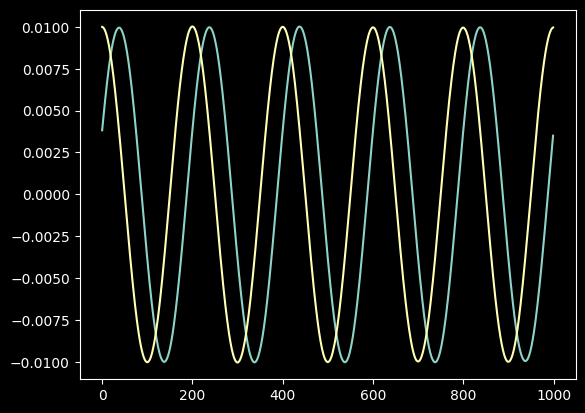

In [113]:
plt.plot(s1[:5*fs//f])
plt.plot(s2[:5*fs//f])
plt.show()

In [114]:
s1 = gaussian_filter(s1, sigma=5)
s2 = gaussian_filter(s2, sigma=5)
corr12 = signal.correlate(s1, s2)
corr12 = corr12 / np.max(corr12)
lags12 = signal.correlation_lags(len(s1), len(s2))
lag12 = lags12[np.argmax(corr12)] / fs

corr13 = signal.correlate(s2, s3)
corr13 = corr13 / np.max(corr13)
lags23 = signal.correlation_lags(len(s2), len(s3))
lag23 = lags23[np.argmax(corr13)] / fs
print(f'真实时延tau12: {t12}\n估计时延lag12: {lag12}\n差异: {np.abs(t12 - lag12) / t12 * 100:.2f}%')
print(f'真实时延tau23: {t23}\n估计时延lag23: {lag23}\n差异: {np.abs(t23 - lag23) / t23 * 100:.2f}%')

真实时延tau12: 5.00056245780911e-06
估计时延lag12: 5.066666666666667e-06
差异: 1.32%
真实时延tau23: 4.999437457816688e-06
估计时延lag23: 4.933333333333333e-06
差异: 1.32%


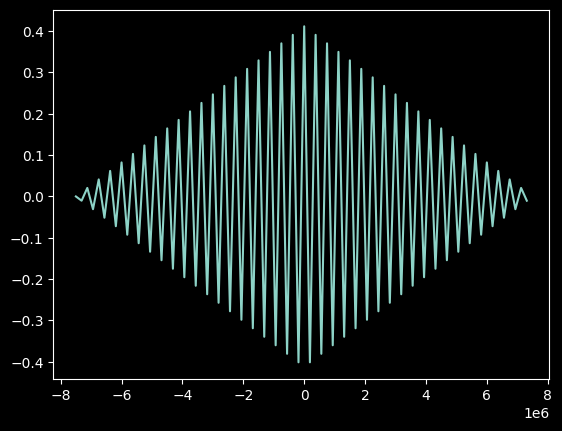

In [115]:
scale = 40
plt.plot(lags12[::fs//scale], corr12[::fs//scale])

In [116]:
r_e, theta_e = far_locate(lag12, lag23, c, K, d)
# 可视化
print(f'真实: ({r}, {theta/pi*180})\n估计: ({r_e}, {theta_e/pi*180})')
print(far_locate(t12, t23, c, K, d))

真实: (100, 60.0)
估计: (0.8437499999999992, 60.00000000000001)
(100.00000123606188, 1.0471975560679445)
